[*********************100%***********************]  1 of 1 completed


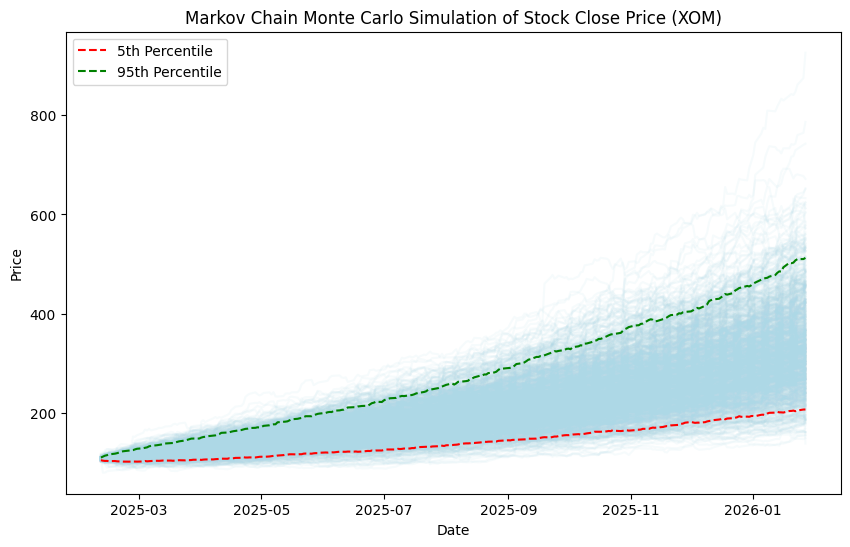

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start_date, end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

ticker_symbol = "XOM"
start_date = "2000-01-01"
end_date = "2025-02-10"
stock_data = get_stock_data(ticker_symbol, start_date, end_date).dropna()
stock_data = stock_data.asfreq('B')  # Set business day frequency

# Calculate daily returns with explicit handling of missing values
stock_data['Daily Return'] = stock_data['Close'].pct_change(fill_method=None)

# Calculate mean and standard deviation of returns
mean_return = stock_data['Daily Return'].mean()
std_return = stock_data['Daily Return'].std()

# Define thresholds for classification
thresholds = {
    1.0: mean_return + 1.0 * std_return,
    0.9: mean_return + 0.9 * std_return,
    0.8: mean_return + 0.8 * std_return,
    0.7: mean_return + 0.7 * std_return,
    0.6: mean_return + 0.6 * std_return,
    0.5: mean_return + 0.5 * std_return,
    0.4: mean_return + 0.4 * std_return,
    0.3: mean_return + 0.3 * std_return,
    0.2: mean_return + 0.2 * std_return,
    0.1: mean_return + 0.1 * std_return,
    -0.1: mean_return - 0.1 * std_return,
    -0.2: mean_return - 0.2 * std_return,
    -0.3: mean_return - 0.3 * std_return,
    -0.4: mean_return - 0.4 * std_return,
    -0.5: mean_return - 0.5 * std_return,
    -0.6: mean_return - 0.6 * std_return,
    -0.7: mean_return - 0.7 * std_return,
    -0.8: mean_return - 0.8 * std_return,
    -0.9: mean_return - 0.9 * std_return,
    -1.0: mean_return - 1.0 * std_return,
}

def classify_state(return_value):
    for sigma in sorted(thresholds.keys(), reverse=True):
        if return_value > thresholds[sigma]:
            return f'Up {abs(sigma):.1f}σ'
        elif return_value < thresholds.get(-sigma if sigma != 0 else sigma, -np.inf):
            return f'Down {abs(sigma):.1f}σ'
    return 'Stagnant'

# Apply classification
stock_data['Markov State'] = stock_data['Daily Return'].apply(classify_state)
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create transition matrix
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Ensure all states are present in the transition matrix
all_sigmas = sorted([abs(k) for k in thresholds.keys()] + [0], reverse=True)
states = []
for sigma in all_sigmas:
    if sigma > 0:
        states.append(f'Up {sigma:.1f}σ')
    elif sigma < 0:
        states.append(f'Down {abs(sigma):.1f}σ')
    else:
        states.append('Stagnant')
states = list(dict.fromkeys(states))  # Remove duplicates

# Reindex the transition matrix to include all states
transition_matrix = transition_matrix.reindex(index=states, columns=states, fill_value=0.0)

# Normalize rows to ensure probabilities sum to 1
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0.0)

# Monte Carlo Simulation
n_simulations = 1000
n_days = 252
initial_price = stock_data['Close'].iloc[-1].item()  # Ensure it's a scalar

# Fit Student's t-distribution
params = t.fit(stock_data['Daily Return'].dropna())
df_t, mu, sigma = params

# Simulate paths
simulated_paths = []
for _ in range(n_simulations):
    simulated_returns = []
    current_state = stock_data['Markov State'].iloc[-1]

    for day in range(n_days):
        # Generate return based on current state
        if "Up" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_return = t.rvs(df_t, loc=mu + sigma_factor * sigma, scale=sigma)
        elif "Down" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_return = t.rvs(df_t, loc=mu - sigma_factor * sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)

        simulated_returns.append(daily_return)

        # Transition to next state
        if current_state in transition_matrix.index:
            # Ensure probabilities sum to 1
            probs = transition_matrix.loc[current_state].values
            probs = probs / probs.sum()  # Normalize probabilities
            current_state = np.random.choice(
                transition_matrix.columns,
                p=probs
            )
        else:
            # Fallback: choose a state uniformly at random
            current_state = np.random.choice(states)

    # Calculate cumulative returns and prices
    cumulative_returns = np.cumsum(simulated_returns)
    simulated_prices = initial_price * np.exp(cumulative_returns)
    simulated_paths.append(simulated_prices)

# Convert to DataFrame with proper index
start_date_simulation = stock_data.index[-1] + pd.Timedelta(days=1)
dates = pd.date_range(start=start_date_simulation, periods=n_days, freq='B')
simulated_paths_df = pd.DataFrame(simulated_paths).T
simulated_paths_df.index = dates

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)
plt.plot(simulated_paths_df.quantile(0.05, axis=1), color="red", linestyle="--", label="5th Percentile")
plt.plot(simulated_paths_df.quantile(0.95, axis=1), color="green", linestyle="--", label="95th Percentile")
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


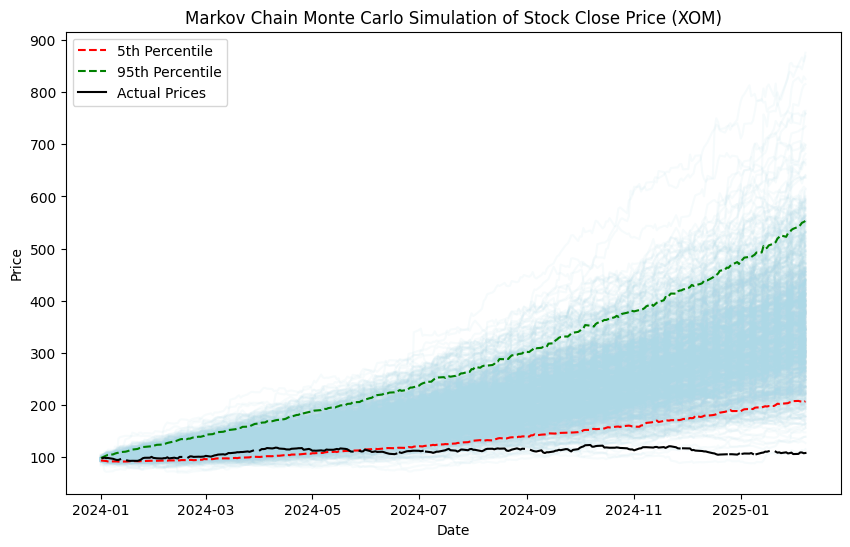

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start_date, end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

ticker_symbol = "XOM"
start_date = "2000-01-01"
end_date = "2025-02-10"
stock_data = get_stock_data(ticker_symbol, start_date, end_date).dropna()
stock_data = stock_data.asfreq('B')  # Set business day frequency

# Calculate daily returns with explicit handling of missing values
stock_data['Daily Return'] = stock_data['Close'].pct_change(fill_method=None)

# Calculate mean and standard deviation of returns
mean_return = stock_data['Daily Return'].mean()
std_return = stock_data['Daily Return'].std()

# Define thresholds for classification
thresholds = {
    1.0: mean_return + 1.0 * std_return,
    0.9: mean_return + 0.9 * std_return,
    0.8: mean_return + 0.8 * std_return,
    0.7: mean_return + 0.7 * std_return,
    0.6: mean_return + 0.6 * std_return,
    0.5: mean_return + 0.5 * std_return,
    0.4: mean_return + 0.4 * std_return,
    0.3: mean_return + 0.3 * std_return,
    0.2: mean_return + 0.2 * std_return,
    0.1: mean_return + 0.1 * std_return,
    -0.1: mean_return - 0.1 * std_return,
    -0.2: mean_return - 0.2 * std_return,
    -0.3: mean_return - 0.3 * std_return,
    -0.4: mean_return - 0.4 * std_return,
    -0.5: mean_return - 0.5 * std_return,
    -0.6: mean_return - 0.6 * std_return,
    -0.7: mean_return - 0.7 * std_return,
    -0.8: mean_return - 0.8 * std_return,
    -0.9: mean_return - 0.9 * std_return,
    -1.0: mean_return - 1.0 * std_return,
}

def classify_state(return_value):
    for sigma in sorted(thresholds.keys(), reverse=True):
        if return_value > thresholds[sigma]:
            return f'Up {abs(sigma):.1f}σ'
        elif return_value < thresholds.get(-sigma if sigma != 0 else sigma, -np.inf):
            return f'Down {abs(sigma):.1f}σ'
    return 'Stagnant'

# Apply classification
stock_data['Markov State'] = stock_data['Daily Return'].apply(classify_state)
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create transition matrix
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Ensure all states are present in the transition matrix
all_sigmas = sorted([abs(k) for k in thresholds.keys()] + [0], reverse=True)
states = []
for sigma in all_sigmas:
    if sigma > 0:
        states.append(f'Up {sigma:.1f}σ')
    elif sigma < 0:
        states.append(f'Down {abs(sigma):.1f}σ')
    else:
        states.append('Stagnant')
states = list(dict.fromkeys(states))  # Remove duplicates

# Reindex the transition matrix to include all states
transition_matrix = transition_matrix.reindex(index=states, columns=states, fill_value=0.0)

# Normalize rows to ensure probabilities sum to 1
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0.0)

# Split data into training and testing sets
split_date = '2024-01-01'  # Define the split date
training_data = stock_data[stock_data.index < split_date]
testing_data = stock_data[stock_data.index >= split_date]

# Monte Carlo Simulation
n_simulations = 1000
n_days = len(testing_data)  # Use the length of the testing set
initial_price = training_data['Close'].iloc[-1].item()  # Use the last price from the training set

# Fit Student's t-distribution
params = t.fit(training_data['Daily Return'].dropna())
df_t, mu, sigma = params

# Simulate paths
simulated_paths = []
for _ in range(n_simulations):
    simulated_returns = []
    current_state = training_data['Markov State'].iloc[-1]

    for day in range(n_days):
        # Generate return based on current state
        if "Up" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_return = t.rvs(df_t, loc=mu + sigma_factor * sigma, scale=sigma)
        elif "Down" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_return = t.rvs(df_t, loc=mu - sigma_factor * sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)

        simulated_returns.append(daily_return)

        # Transition to next state
        if current_state in transition_matrix.index:
            # Ensure probabilities sum to 1
            probs = transition_matrix.loc[current_state].values
            probs = probs / probs.sum()  # Normalize probabilities
            current_state = np.random.choice(
                transition_matrix.columns,
                p=probs
            )
        else:
            # Fallback: choose a state uniformly at random
            current_state = np.random.choice(states)

    # Calculate cumulative returns and prices
    cumulative_returns = np.cumsum(simulated_returns)
    simulated_prices = initial_price * np.exp(cumulative_returns)
    simulated_paths.append(simulated_prices)

# Convert to DataFrame with proper index
dates = testing_data.index
simulated_paths_df = pd.DataFrame(simulated_paths).T
simulated_paths_df.index = dates

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)
plt.plot(simulated_paths_df.quantile(0.05, axis=1), color="red", linestyle="--", label="5th Percentile")
plt.plot(simulated_paths_df.quantile(0.95, axis=1), color="green", linestyle="--", label="95th Percentile")
plt.plot(testing_data.index, testing_data['Close'], color="black", label="Actual Prices")
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


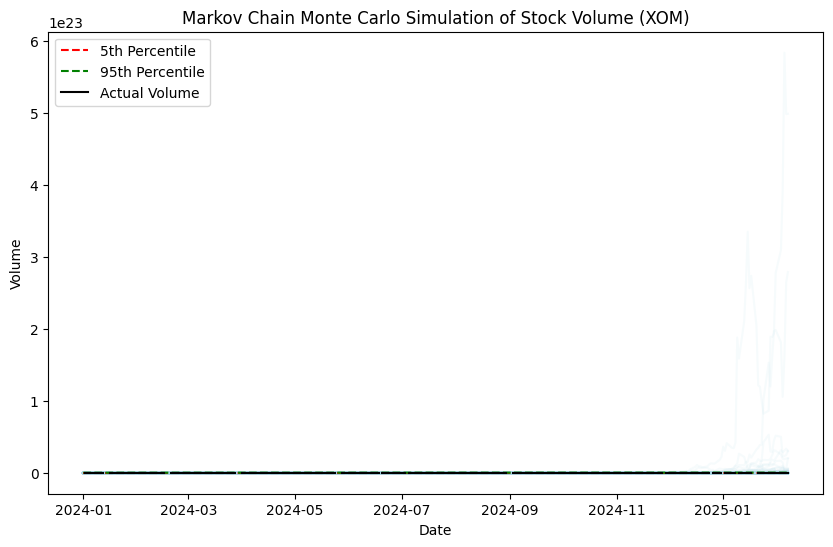

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start_date, end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

ticker_symbol = "XOM"
start_date = "2000-01-01"
end_date = "2025-02-10"
stock_data = get_stock_data(ticker_symbol, start_date, end_date).dropna()
stock_data = stock_data.asfreq('B')  # Set business day frequency

# Calculate daily volume changes with explicit handling of missing values
stock_data['Daily Volume Change'] = stock_data['Volume'].pct_change(fill_method=None)

# Calculate mean and standard deviation of volume changes
mean_volume_change = stock_data['Daily Volume Change'].mean()
std_volume_change = stock_data['Daily Volume Change'].std()

# Define thresholds for classification (original thresholds)
thresholds = {
    1.0: mean_volume_change + 1.0 * std_volume_change,
    0.9: mean_volume_change + 0.9 * std_volume_change,
    0.8: mean_volume_change + 0.8 * std_volume_change,
    0.7: mean_volume_change + 0.7 * std_volume_change,
    0.6: mean_volume_change + 0.6 * std_volume_change,
    0.5: mean_volume_change + 0.5 * std_volume_change,
    0.4: mean_volume_change + 0.4 * std_volume_change,
    0.3: mean_volume_change + 0.3 * std_volume_change,
    0.2: mean_volume_change + 0.2 * std_volume_change,
    0.1: mean_volume_change + 0.1 * std_volume_change,
    -0.1: mean_volume_change - 0.1 * std_volume_change,
    -0.2: mean_volume_change - 0.2 * std_volume_change,
    -0.3: mean_volume_change - 0.3 * std_volume_change,
    -0.4: mean_volume_change - 0.4 * std_volume_change,
    -0.5: mean_volume_change - 0.5 * std_volume_change,
    -0.6: mean_volume_change - 0.6 * std_volume_change,
    -0.7: mean_volume_change - 0.7 * std_volume_change,
    -0.8: mean_volume_change - 0.8 * std_volume_change,
    -0.9: mean_volume_change - 0.9 * std_volume_change,
    -1.0: mean_volume_change - 1.0 * std_volume_change,
}

def classify_state(volume_change):
    for sigma in sorted(thresholds.keys(), reverse=True):
        if volume_change > thresholds[sigma]:
            return f'Up {abs(sigma):.1f}σ'
        elif volume_change < thresholds.get(-sigma if sigma != 0 else sigma, -np.inf):
            return f'Down {abs(sigma):.1f}σ'
    return 'Stagnant'

# Apply classification
stock_data['Markov State'] = stock_data['Daily Volume Change'].apply(classify_state)
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create transition matrix
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Ensure all states are present in the transition matrix
all_sigmas = sorted([abs(k) for k in thresholds.keys()] + [0], reverse=True)
states = []
for sigma in all_sigmas:
    if sigma > 0:
        states.append(f'Up {sigma:.1f}σ')
    elif sigma < 0:
        states.append(f'Down {abs(sigma):.1f}σ')
    else:
        states.append('Stagnant')
states = list(dict.fromkeys(states))  # Remove duplicates

# Reindex the transition matrix to include all states
transition_matrix = transition_matrix.reindex(index=states, columns=states, fill_value=0.0)

# Normalize rows to ensure probabilities sum to 1
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0.0)

# Split data into training and testing sets
split_date = '2024-01-01'  # Define the split date
training_data = stock_data[stock_data.index < split_date]
testing_data = stock_data[stock_data.index >= split_date]

# Monte Carlo Simulation
n_simulations = 1000
n_days = len(testing_data)  # Use the length of the testing set
initial_volume = training_data['Volume'].iloc[-1].item()  # Use the last volume from the training set

# Fit Student's t-distribution
params = t.fit(training_data['Daily Volume Change'].dropna())
df_t, mu, sigma = params

# Simulate paths
simulated_paths = []
for _ in range(n_simulations):
    simulated_changes = []
    current_state = training_data['Markov State'].iloc[-1]

    for day in range(n_days):
        # Generate volume change based on current state
        if "Up" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_change = t.rvs(df_t, loc=mu + sigma_factor * sigma, scale=sigma)
        elif "Down" in current_state:
            sigma_factor = float(current_state.split(' ')[1].replace('σ', ''))
            daily_change = t.rvs(df_t, loc=mu - sigma_factor * sigma, scale=sigma)
        else:
            daily_change = t.rvs(df_t, loc=mu, scale=sigma)

        simulated_changes.append(daily_change)

        # Transition to next state
        if current_state in transition_matrix.index:
            # Ensure probabilities sum to 1
            probs = transition_matrix.loc[current_state].values
            probs = probs / probs.sum()  # Normalize probabilities
            current_state = np.random.choice(
                transition_matrix.columns,
                p=probs
            )
        else:
            # Fallback: choose a state uniformly at random
            current_state = np.random.choice(states)

    # Calculate cumulative volume changes and predicted volumes
    cumulative_changes = np.cumsum(simulated_changes)
    simulated_volumes = initial_volume * np.exp(cumulative_changes)
    simulated_paths.append(simulated_volumes)

# Convert to DataFrame with proper index
dates = testing_data.index
simulated_paths_df = pd.DataFrame(simulated_paths).T
simulated_paths_df.index = dates

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)
plt.plot(simulated_paths_df.quantile(0.05, axis=1), color="red", linestyle="--", label="5th Percentile")
plt.plot(simulated_paths_df.quantile(0.95, axis=1), color="green", linestyle="--", label="95th Percentile")
plt.plot(testing_data.index, testing_data['Volume'], color="black", label="Actual Volume")
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Volume ({ticker_symbol})")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

,Close,High,Low,Open,Volume,Daily Volume Change,Markov State,Prev State
Date,,,,,,,,
2024-01-01,95.824905,96.409548,95.479866,96.198697,17741400.0,0.000000,Up 1.0σ,Up 1.0σ
2024-01-02,98.106003,98.815247,96.658755,96.725846,23483000.0,0.323627,Up 1.0σ,Up 1.0σ
2024-01-03,98.930267,99.313645,97.435102,98.019744,23490800.0,0.000332,Up 1.0σ,Up 1.0σ
2024-01-04,98.067657,100.224149,97.808882,99.754515,19395200.0,-0.174349,Up 1.0σ,Up 1.0σ
2024-01-05,98.364784,99.102788,97.885564,98.882343,15825000.0,-0.184076,Up 1.0σ,Up 1.0σ


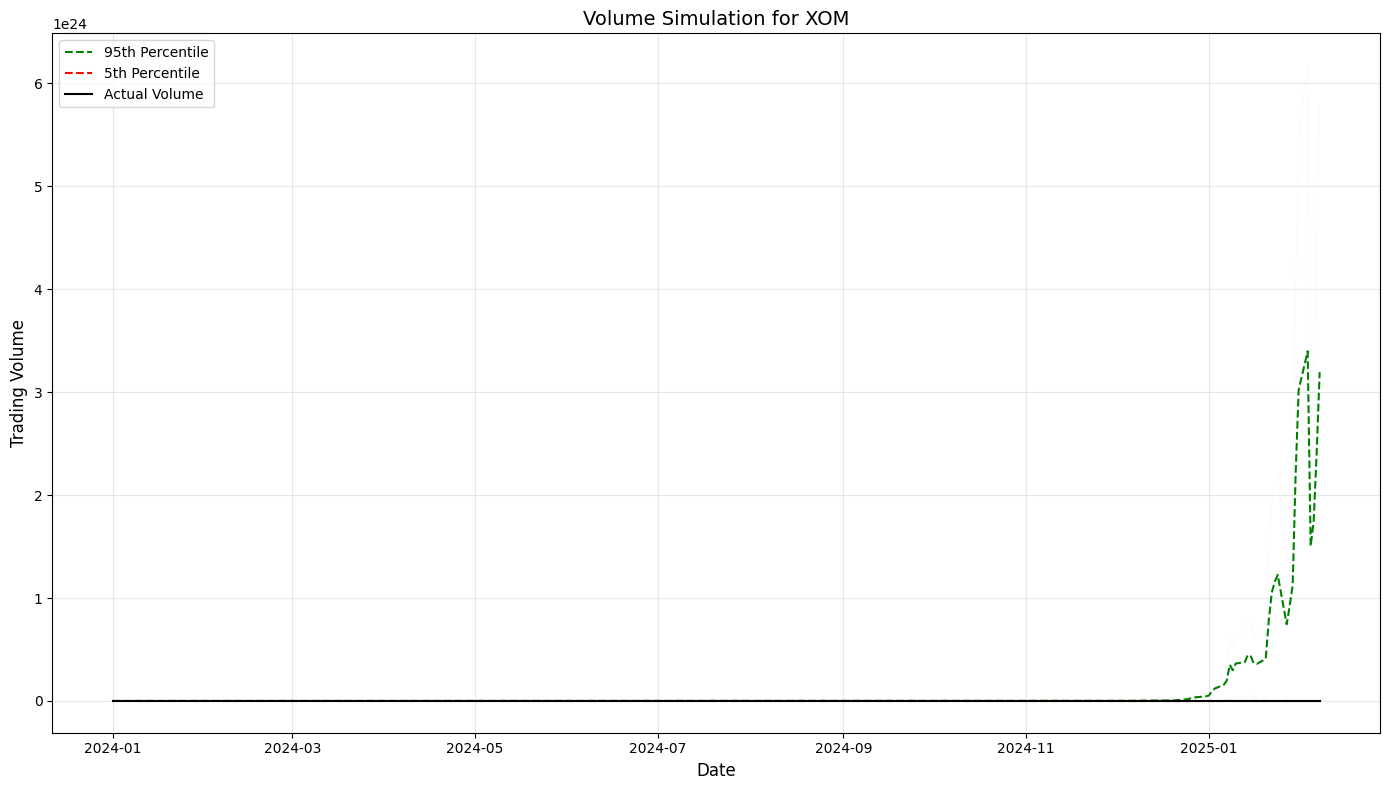

from matplotlib import pyplot as plt
_df_0['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Close', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Low', y='Open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Open', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Low']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Low', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Low')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Low']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Low', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Low')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Low']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Low', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Low')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Low']
  ys = series['Volume']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Low', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Low')
_ = plt.ylabel('Volume')

from matplotlib import pyplot as plt
_df_12['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#!pip install yfinance==0.2.54
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from tenacity import retry, wait_exponential, stop_after_attempt

# Configure API settings
#yf.pdr_override()

@retry(wait=wait_exponential(multiplier=1, min=4, max=10), stop=stop_after_attempt(5))
def get_stock_data(ticker, start_date, end_date):
    return yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False,
        multi_level_index=False
    )

# Configuration
ticker_symbol = "XOM"
start_date = "2000-01-01"
end_date = "2025-02-10"

# Data pipeline
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data = stock_data.resample('B').last().ffill()  # Better business day handling

# Volume processing
stock_data['Volume'] = stock_data['Volume'].replace(0, np.nan).ffill()
stock_data['Daily Volume Change'] = stock_data['Volume'].pct_change(fill_method=None).fillna(0)

# Statistical parameters
mean_vol = stock_data['Daily Volume Change'].mean()
std_vol = stock_data['Daily Volume Change'].std()

# State thresholds
thresholds = {}
for s in np.arange(0.1, 1.1, 0.1):
    thresholds[s] = mean_vol + s * std_vol
    thresholds[-s] = mean_vol - s * std_vol

# State classification
def classify_state(change):
    for sigma in sorted(thresholds.keys(), key=abs, reverse=True):
        if change > thresholds.get(sigma, np.inf):
            return f'Up {abs(sigma):.1f}σ'
        elif change < thresholds.get(-sigma, -np.inf):
            return f'Down {abs(sigma):.1f}σ'
    return 'Neutral'

stock_data['Markov State'] = stock_data['Daily Volume Change'].apply(classify_state)
stock_data['Prev State'] = stock_data['Markov State'].shift(1).fillna('Neutral')

# Transition matrix
states = [f'Up {s:.1f}σ' for s in np.arange(1.0, 0.0, -0.1)] + ['Neutral'] + [f'Down {s:.1f}σ' for s in np.arange(0.1, 1.1, 0.1)]
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'], rownames=['From'], colnames=['To'])
transition_matrix = transition_counts.reindex(index=states, columns=states, fill_value=1e-6)
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1) + 1e-6, axis=0)

# Data splitting
split_date = '2024-01-01'
training_data = stock_data[stock_data.index < split_date]
testing_data = stock_data[stock_data.index >= split_date]



# Simulation parameters
n_simulations = 10
n_days = len(testing_data)
initial_volume = float(training_data['Volume'].iloc[-1])  # Ensure scalar value

# Distribution fitting
params = t.fit(training_data['Daily Volume Change'].replace([np.inf, -np.inf], np.nan).dropna())
df_t, mu, sigma = params

# Monte Carlo simulation
simulated_paths = []
for _ in range(n_simulations):
    current_volume = initial_volume
    current_state = training_data['Markov State'].iloc[-1]
    path = []

    for _ in range(n_days):
        # Generate volume change
        if "Up" in current_state:
            sigma_factor = float(current_state.split()[1].replace('σ', ''))
            change = t.rvs(df_t, loc=mu + sigma_factor*sigma, scale=sigma)
        elif "Down" in current_state:
            sigma_factor = float(current_state.split()[1].replace('σ', ''))
            change = t.rvs(df_t, loc=mu - sigma_factor*sigma, scale=sigma)
        else:
            change = t.rvs(df_t, loc=mu, scale=sigma)

        # Update volume with bounds checking
        current_volume = max(current_volume * (1 + change), 0)
        path.append(current_volume)

        # State transition
        current_state = np.random.choice(
            transition_matrix.columns,
            p=transition_matrix.loc[current_state].values
        )

    simulated_paths.append(pd.Series(path, index=testing_data.index[:len(path)]))

# Results processing
simulated_paths_df = pd.concat(simulated_paths, axis=1)
simulated_paths_df = simulated_paths_df.clip(lower=0)

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(simulated_paths_df, color='skyblue', alpha=0.1, linewidth=0.5)
plt.plot(simulated_paths_df.quantile(0.95, axis=1), color='green',
         linestyle='--', label='95th Percentile')
plt.plot(simulated_paths_df.quantile(0.05, axis=1), color='red',
         linestyle='--', label='5th Percentile')
plt.plot(testing_data['Volume'], color='black', linewidth=1.5, label='Actual Volume')
plt.title(f'Volume Simulation for {ticker_symbol}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
testing_data.head()
#plt.show()


In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Download hourly volume data for AAPL
data = yf.download('AAPL', interval='60m', period='60d')  # last 60 days, hourly
volume_data = data['Volume'].dropna().astype(int)

# Discretize volume into many states (e.g., 30 bins)
n_states = 30
volume_bins = np.linspace(volume_data.min(), volume_data.max(), n_states + 1)

# Ensure bins is 1-dimensional
if volume_bins.ndim > 1:
    volume_bins = volume_bins.flatten()

# Check for monotonicity
if not (np.all(np.diff(volume_bins) > 0) or np.all(np.diff(volume_bins) < 0)):
    raise ValueError("Bins must be monotonic")

# Digitize the volume data
states = np.digitize(volume_data, volume_bins) - 1  # state indices 0 ... n_states-1

# Build transition matrix
transition_matrix = np.zeros((n_states, n_states))
for (i, j) in zip(states[:-1], states[1:]):
    transition_matrix[i, j] += 1
# Normalize rows to get probabilities
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.divide(transition_matrix, row_sums, out=np.zeros_like(transition_matrix), where=row_sums!=0)

# Split into train/test
split_idx = int(0.8 * len(states))
train_states = states[:split_idx]
test_states = states[split_idx:]

# Monte Carlo simulation: simulate many possible future paths
n_sim = 1000
n_steps = len(test_states)
simulations = np.zeros((n_sim, n_steps), dtype=int)

for sim in range(n_sim):
    current_state = train_states[-1]
    for t in range(n_steps):
        probs = transition_matrix[current_state]
        if probs.sum() == 0:
            # If no outgoing transitions, pick a random state
            next_state = np.random.randint(n_states)
        else:
            next_state = np.random.choice(np.arange(n_states), p=probs)
        simulations[sim, t] = next_state
        current_state = next_state

# Convert simulated states back to volume
bin_centers = (volume_bins[:-1] + volume_bins[1:]) / 2
simulated_volumes = bin_centers[simulations]

# Calculate prediction intervals
lower = np.percentile(simulated_volumes, 2.5, axis=0)
upper = np.percentile(simulated_volumes, 97.5, axis=0)
median = np.median(simulated_volumes, axis=0)
actual = volume_data.iloc[split_idx:split_idx+n_steps].values

# Plot results
plt.figure(figsize=(16,9))
plt.plot(range(n_steps), actual, color='green', label='Actual Volume')
plt.plot(range(n_steps), median, color='black', label='Predicted Median Volume')
plt.fill_between(range(n_steps), lower, upper, color='grey', alpha=0.3, label='95% Prediction Interval')
plt.xlabel('Hour (test set)')
plt.ylabel('Volume')
plt.title('AAPL Hourly Volume Prediction with Large-State Markov Chain')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


IndexError: index 30 is out of bounds for axis 1 with size 30